In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import transforms
import numpy as np
import PIL

In [15]:
# hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3 # change according to data
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 16
FEATURES_GEN = 16

In [16]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input: N x noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0), # N x f_g * 16 x 4 x 4
            self._block(features_g * 16, features_g * 8, 4, 2, 1), # 8 x 8
            self._block(features_g * 8, features_g*4, 4, 2, 1), # 16 x 16
            self._block(features_g * 4, features_g*2, 4, 2, 1), # 32 x 32
            # don't use another block because we dont want batch normalization
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1,
            ),
            nn.Tanh(), # forces image to be between range [-1, 1] for more effective training
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

In [17]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
gen.load_state_dict(torch.load("./models/Generator"))
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [18]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [19]:
fixed_noise = torch.randn(1, 100, 1, 1).to(device)
fake = gen(fixed_noise)

fake_img = torchvision.utils.make_grid(
                    fake[:1], normalize=True
                )

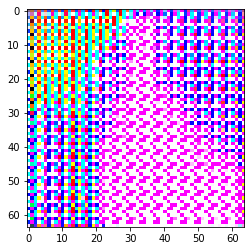

In [20]:
show(fake_img)

In [21]:
print(fake_img.size())


torch.Size([3, 64, 64])
